#### Experiment filtering up and down methods

Might have to experiment with invr file 

### First create a custom dataframe to experiment

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as geom

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
index = list(range(0, 16))
values = list(range(1, 17))

In [3]:
df = pd.DataFrame({'FIPS': box_names,'Index': index, 'Value': values})

In [4]:
df.head()

,FIPS,Index,Value
0,A,0,1
1,B,1,2
2,C,2,3
3,D,3,4
4,E,4,5


In [5]:
# Sorting the DataFrame based on the 'rate' column :::: Values are needed to be sorted in ascending order
df.sort_values(by='Value', inplace=True)

# Adding a new column 'new_ID' with ID values starting from zero
df['sortedID'] = range(len(df))

In [6]:
df.head()

,FIPS,Index,Value,sortedID
0,A,0,1,0
1,B,1,2,1
2,C,2,3,2
3,D,3,4,3
4,E,4,5,4


In [7]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    value = row['Index']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [8]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [9]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

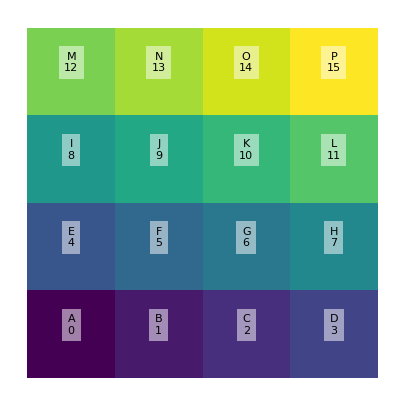

In [10]:
# plot the geodataframe

# Compute centroids separately to avoid warning
gdf['centroid'] = gdf.geometry.centroid  

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, column='Value', cmap='viridis', legend=False)

# Add FIPS and Value labels at centroids
for x, y, fips, value in zip(gdf.centroid.x, gdf.centroid.y, gdf['FIPS'], gdf['sortedID']):
    ax.text(x, y, f"{fips}\n{value}", fontsize=8, ha='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.axis('off')
plt.show()

In [11]:
gdf = gdf[['FIPS','Value', 'geometry']]  

### Creating a custom function to employ filtering up/down

Need to prepare the data for the next step

In [12]:
gdf.head()

,FIPS,Value,geometry
0,A,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
1,B,2,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
2,C,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
3,D,4,"POLYGON ((3.000 0.000, 4.000 0.000, 4.000 1.00..."
4,E,5,"POLYGON ((0.000 1.000, 1.000 1.000, 1.000 2.00..."


In [13]:
# sort the data based on the 'Value' column
# gdf.sort_values(by='Value', inplace=True)
gdf.sort_values(by='Value', ascending=False, inplace=True)

# add sortedID column
gdf['sortedID'] = range(len(gdf))

# make it a geodataframe
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# set the CRS   # This is a commonly used projected CRS # check this again
gdf.crs = "EPSG:4326"

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_86825/1286392328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.sort_values(by='Value', ascending=False, inplace=True)
/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
gdf.head()

,FIPS,Value,geometry,sortedID
15,P,16,"POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4....",0
14,O,15,"POLYGON ((2.00000 3.00000, 3.00000 3.00000, 3....",1
13,N,14,"POLYGON ((1.00000 3.00000, 2.00000 3.00000, 2....",2
12,M,13,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",3
11,L,12,"POLYGON ((3.00000 2.00000, 4.00000 2.00000, 4....",4


Generate adjacent counties dataframe

In [15]:
import invr
import io
from PIL import Image

In [16]:
def generate_adjacent_counties(dataframe, variable_name=None, threshold=None):
    """
    Generate adjacent counties based on the given GeoDataFrame and a specified variable.
    
    Parameters:
    ----------
    dataframe : gpd.GeoDataFrame
        A GeoDataFrame containing county-level spatial data.
        It should include at least the following columns:
        - 'sortedID' (str or int): Unique identifier for each county.
        - 'geometry' (shapely.geometry): Geometric representation of county boundaries.
        - (Optional) Other county-level attributes that can be used for filtering.
    
    variable_name : str, optional
        The column name of the variable used for filtering (e.g., population, opioid overdose rate, income).
    
    threshold : tuple, optional
        A tuple (min_value, max_value) specifying the range for filtering the counties 
        based on `variable_name`.

    Returns:
    -------
    adjacencies_list : list
        A list containing adjacent county IDs for each county in the filtered dataset.
    
    merged_df : gpd.GeoDataFrame
        A GeoDataFrame with counties and their corresponding attributes, including adjacency relationships.
    
    county_list : list
        A list of counties included in the filtered dataset.
    """

    # Ensure the input is a GeoDataFrame
    if not isinstance(dataframe, gpd.GeoDataFrame):
        raise ValueError("Input dataframe must be a GeoDataFrame with a valid 'geometry' column.")

    # Filter the dataframe based on the variable and threshold
    if variable_name and threshold:
        filtered_df = dataframe[(dataframe[variable_name] >= threshold[0]) & (dataframe[variable_name] <= threshold[1])]
    else:
        filtered_df = dataframe.copy()

    # Perform spatial join to find adjacent counties
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

    # Exclude self-joins (where a county intersects itself)
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')

    # Group by county and list its adjacent counties
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()
    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)

    # Extract adjacency list and county list
    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()

    # Merge adjacency info with original dataset
    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county', right_on='sortedID', how='left')

    # Convert to GeoDataFrame to retain spatial properties
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

    # Define the Coordinate Reference System (CRS)
    merged_df.crs = "EPSG:4326"

    return adjacencies_list, merged_df, county_list


In [17]:
# sortedID has been used as the unique identifier for counties hereonwards

In [18]:
adjacencies_list, adjacent_counties_df, county_list = generate_adjacent_counties(gdf)

In [19]:
adjacent_counties_df

,county,adjacent,FIPS,Value,geometry,sortedID
0,0,"[5, 4, 1]",P,16,"POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4....",0
1,1,"[6, 2, 5, 4, 0]",O,15,"POLYGON ((2.00000 3.00000, 3.00000 3.00000, 3....",1
2,2,"[7, 6, 3, 5, 1]",N,14,"POLYGON ((1.00000 3.00000, 2.00000 3.00000, 2....",2
3,3,"[7, 6, 2]",M,13,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",3
4,4,"[8, 9, 5, 0, 1]",L,12,"POLYGON ((3.00000 2.00000, 4.00000 2.00000, 4....",4
5,5,"[10, 6, 2, 8, 9, 4, 0, 1]",K,11,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",5
6,6,"[11, 10, 7, 3, 2, 9, 5, 1]",J,10,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",6
7,7,"[11, 10, 6, 3, 2]",I,9,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",7
8,8,"[12, 13, 9, 5, 4]",H,8,"POLYGON ((3.00000 1.00000, 4.00000 1.00000, 4....",8
9,9,"[14, 10, 6, 12, 13, 8, 5, 4]",G,7,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",9


In [20]:
adjacencies_list

[[5, 4, 1],
 [6, 2, 5, 4, 0],
 [7, 6, 3, 5, 1],
 [7, 6, 2],
 [8, 9, 5, 0, 1],
 [10, 6, 2, 8, 9, 4, 0, 1],
 [11, 10, 7, 3, 2, 9, 5, 1],
 [11, 10, 6, 3, 2],
 [12, 13, 9, 5, 4],
 [14, 10, 6, 12, 13, 8, 5, 4],
 [15, 14, 11, 7, 6, 13, 9, 5],
 [15, 14, 10, 7, 6],
 [13, 8, 9],
 [14, 10, 12, 8, 9],
 [15, 11, 10, 13, 9],
 [14, 11, 10]]

In [21]:
county_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [22]:
# create a dictionary with county names and their adjacent counties
adjacent_counties_dict = dict(zip(adjacent_counties_df['county'], adjacent_counties_df['adjacent']))

In [23]:
adjacent_counties_dict

{0: [5, 4, 1],
 1: [6, 2, 5, 4, 0],
 2: [7, 6, 3, 5, 1],
 3: [7, 6, 2],
 4: [8, 9, 5, 0, 1],
 5: [10, 6, 2, 8, 9, 4, 0, 1],
 6: [11, 10, 7, 3, 2, 9, 5, 1],
 7: [11, 10, 6, 3, 2],
 8: [12, 13, 9, 5, 4],
 9: [14, 10, 6, 12, 13, 8, 5, 4],
 10: [15, 14, 11, 7, 6, 13, 9, 5],
 11: [15, 14, 10, 7, 6],
 12: [13, 8, 9],
 13: [14, 10, 12, 8, 9],
 14: [15, 11, 10, 13, 9],
 15: [14, 11, 10]}

Make the simplicial complex

In [24]:
def form_simplicial_complex(adjacent_county_list, county_list):
    """Form a simplicial complex based on adjacent counties."""
    max_dimension = 3
    V = invr.incremental_vr([], adjacent_county_list, max_dimension, county_list)
    return V

In [25]:
simplices = form_simplicial_complex(adjacent_counties_dict, county_list)

In [26]:
simplices

[[0],
 [1],
 [0, 1],
 [2],
 [1, 2],
 [3],
 [2, 3],
 [4],
 [0, 4],
 [1, 4],
 [0, 1, 4],
 [5],
 [0, 5],
 [1, 5],
 [0, 1, 5],
 [2, 5],
 [1, 2, 5],
 [4, 5],
 [0, 4, 5],
 [1, 4, 5],
 [6],
 [1, 6],
 [2, 6],
 [1, 2, 6],
 [3, 6],
 [2, 3, 6],
 [5, 6],
 [1, 5, 6],
 [2, 5, 6],
 [7],
 [2, 7],
 [3, 7],
 [2, 3, 7],
 [6, 7],
 [2, 6, 7],
 [3, 6, 7],
 [8],
 [4, 8],
 [5, 8],
 [4, 5, 8],
 [9],
 [4, 9],
 [5, 9],
 [4, 5, 9],
 [6, 9],
 [5, 6, 9],
 [8, 9],
 [4, 8, 9],
 [5, 8, 9],
 [10],
 [5, 10],
 [6, 10],
 [5, 6, 10],
 [7, 10],
 [6, 7, 10],
 [9, 10],
 [5, 9, 10],
 [6, 9, 10],
 [11],
 [6, 11],
 [7, 11],
 [6, 7, 11],
 [10, 11],
 [6, 10, 11],
 [7, 10, 11],
 [12],
 [8, 12],
 [9, 12],
 [8, 9, 12],
 [13],
 [8, 13],
 [9, 13],
 [8, 9, 13],
 [10, 13],
 [9, 10, 13],
 [12, 13],
 [8, 12, 13],
 [9, 12, 13],
 [14],
 [9, 14],
 [10, 14],
 [9, 10, 14],
 [11, 14],
 [10, 11, 14],
 [13, 14],
 [9, 13, 14],
 [10, 13, 14],
 [15],
 [10, 15],
 [11, 15],
 [10, 11, 15],
 [14, 15],
 [10, 14, 15],
 [11, 14, 15]]

Let's plot this

In [27]:
def fig2img(fig):
     #convert matplot fig to image and return it

     buf = io.BytesIO()
     fig.savefig(buf)
     buf.seek(0)
     img = Image.open(buf)
     return img

In [28]:
def plot_simplicial_complex(dataframe, simplices,variable, list_gif=[]):
    # Extract city centroids
    city_coordinates = {row['sortedID']: np.array((row['geometry'].centroid.x, row['geometry'].centroid.y)) for _, row in dataframe.iterrows()}

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_axis_off() 

    # Plot the "dataframe" DataFrame
    dataframe.plot(ax=ax, edgecolor='black', linewidth=0.3, color="white")

    # Plot the centroid of the large square with values
    for _, row in dataframe.iterrows():
        centroid = row['geometry'].centroid
        text_to_display = f"{row[variable]:.3f}"
        plt.text(centroid.x, centroid.y, text_to_display, fontsize=10, ha='center', color="black")

    # Plot edges and triangles from simplices
    for edge_or_triangle in simplices:
        if len(edge_or_triangle) == 2:
            # Plot an edge
            ax.plot(*zip(*[city_coordinates[vertex] for vertex in edge_or_triangle]), color='red', linewidth=2)
            img = fig2img(fig)
            list_gif.append(img)
        elif len(edge_or_triangle) == 3:
            # Plot a triangle
            ax.add_patch(plt.Polygon([city_coordinates[vertex] for vertex in edge_or_triangle], color='green', alpha=0.2))
            img = fig2img(fig)
            list_gif.append(img)

        #can change above code block
        plt.close(fig)

    return list_gif

In [29]:
list_gif = []

In [30]:
list_gif = plot_simplicial_complex(gdf, simplices, 'Value',list_gif)

In [31]:
list_gif[0].save('test_2.gif', save_all=True,append_images=list_gif[1:],optimize=False,duration=200,loop=0) 